# Notebook with training BNN on synthetic data

## Synthetic data

In [0]:
!pip install pyro-ppl gpflow

     |████████████████████████████████| 522kB 7.9MB/s 
     |████████████████████████████████| 235kB 20.3MB/s 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist

import gpflow
import tensorflow as tf
from api.data_sampling import (gaussian_sampler_2d, 
                               gaussian_data_sampling,
                               gaussian_mixture_data_sampling)
from api.plotting import (plot_2d_data,
                          plot_1d_label_data,
                          plot_variance_and_mean,
                          plot_loss)
from api.bayesian_modules import (BayesianLinear, 
                                  BayesianLinearMFVI,
                                  BNN_1_layer,
                                  BNN_2_layer)
from api.old_pyro_primitives_modules import BNN_1HL

## Example of training BNN, classification

In [0]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

net = NN(28*28, 1024, 10)

Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz


Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz


Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz


Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [0]:
log_softmax = nn.LogSoftmax(dim=1)

def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [0]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [0]:
num_iterations = 5

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/lib/python3.8/site-packages/pyro/primitives.py:345: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn("The `random_module` primitive is deprecated, and will be removed "


Epoch  0  Loss  2107.1220911803402
Epoch  1  Loss  380.54651705376307
Epoch  2  Loss  161.62863537081083
Epoch  3  Loss  112.13573915656407
Epoch  4  Loss  96.76344890074729


In [0]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return torch.argmax(mean, axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0).float()
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 88 %


In [0]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [0]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions = 0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [0]:
print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  1347
Accuracy when made predictions: 95 %


## Synthetic 1D data and fitting GP

In [2]:
gaussian_centers = torch.Tensor([[-1.0/(2**0.5)], [1.0/(2**0.5)]])
data_num = 100
data_sigma_noise = 0.1
sigma = 0.01
init_cov_matrix = torch.eye(1)
cov_matrix_default = sigma*init_cov_matrix
seed = 42
data_1d = gaussian_mixture_data_sampling(gaussian_centers, 
                                         cov_matrix_default, 
                                         data_num, 
                                         seed)

In [3]:
def model_1d(data):
    real_labels = torch.sin(12*data) + 0.66*torch.cos(25*data) + 3
    return real_labels

def noise_labels_model(real_labels, sigma_noise, seed = None):
    loc = 0.   # mean zero
    scale = 1.
    normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    x = normal.rsample([real_labels.shape[0]]) 
    real_labels = real_labels + x*sigma_noise
    return real_labels

real_labels = model_1d(data_1d[:, 0])
noise_labels =  noise_labels_model(real_labels, 
                                   sigma_noise = data_sigma_noise, 
                                   seed = seed).reshape((real_labels.shape[0], 1))
range_for_real_labels = torch.linspace(-1, 1, steps = 1000)
real_labels_range = model_1d(range_for_real_labels)

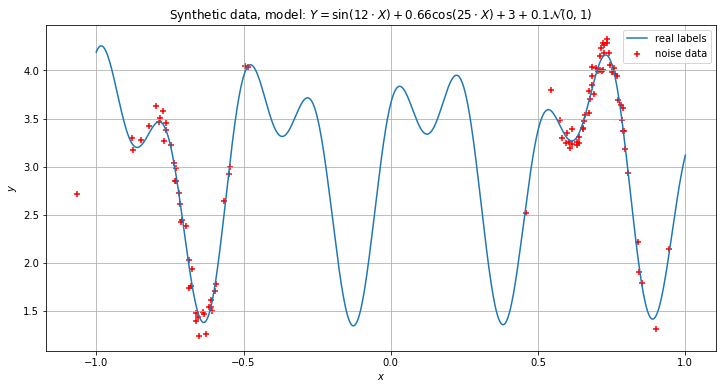

In [4]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data_1d[:, 0], range_for_real_labels, real_labels_range, 
                   noise_labels[:, 0], model_name, figsize = (12, 6))

In [5]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
gp = gpflow.models.GPR(data=(data_1d, noise_labels), kernel=k, mean_function=None)
gp.likelihood.variance.assign(0.01)
gp.kernel.lengthscales.assign(0.3)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

In [6]:
opt = gpflow.optimizers.Scipy()

In [7]:
opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=100))

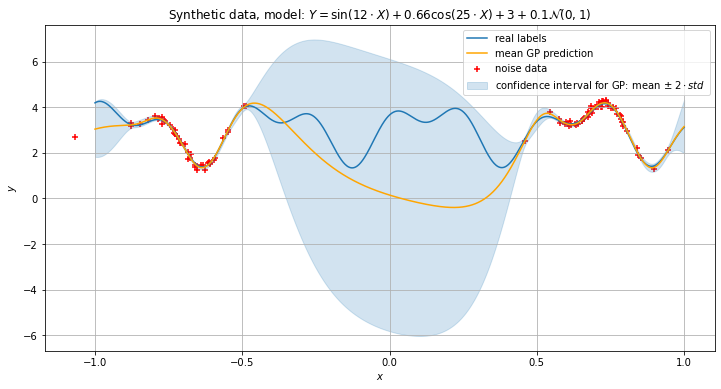

In [8]:
## predict mean and variance of latent GP at test points
xx = np.asarray(range_for_real_labels.reshape(1000, 1).numpy(), 
                dtype = 'float64')
#xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
mean, var = gp.predict_f(xx)

plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mean[:, 0],
                   var_prediction = var[:, 0],
                   model_prediction_name = 'GP')

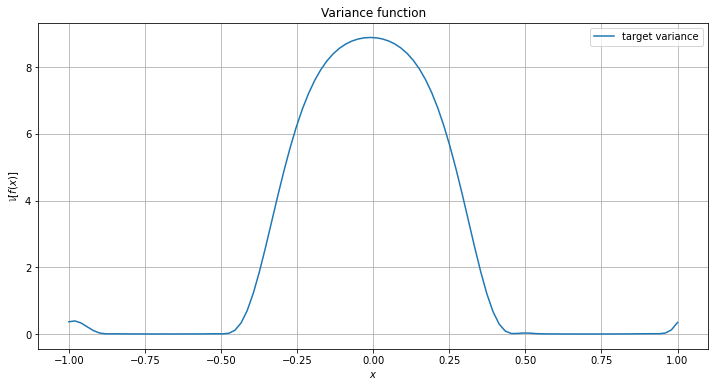

In [9]:
N = 100
grid = np.linspace(-1, 1, num = N).reshape((N, 1))
mean_gp_grid, var_gp_grid = np.array(gp.predict_f(grid))

plot_variance_and_mean(grid[:, 0], target_variance = var_gp_grid[:, 0])

## Training BNN on regression task

In [10]:
device = 'cuda:0'
model = BayesianLinearMFVI(in_features = 1, 
                           out_features = 1, 
                           hidden_features = 50, 
                           n_layers = 1,
                           device = device).to(device)

In [11]:
data_1d_device = data_1d.to(device)
noise_labels_device = noise_labels.to(device)
xx = np.asarray(range_for_real_labels.reshape(1000, 1).numpy(), 
                dtype = 'float64')
torch_test = torch.Tensor(xx)

In [12]:
lr = 1e-4
num_epoch = 10000
loss_arr = model.train_VI_ELBO(x_train = data_1d_device, 
                               y_train = noise_labels_device, 
                               lr = lr,
                               num_epoch = num_epoch)

[iteration 0001] loss: 59962.2130
[iteration 1001] loss: 27390.5805
[iteration 2001] loss: 13398.6924
[iteration 3001] loss: 4829.0222
[iteration 4001] loss: 3390.4197
[iteration 5001] loss: 2985.4011
[iteration 6001] loss: 3050.3494
[iteration 7001] loss: 3363.8604
[iteration 8001] loss: 2905.5406
[iteration 9001] loss: 3071.7290


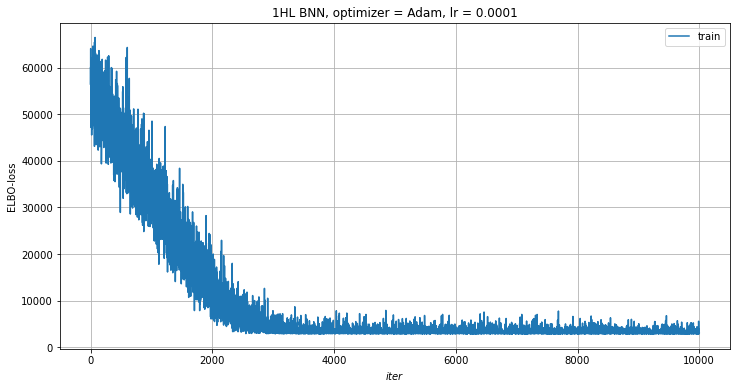

In [14]:
plot_loss(loss_arr, 
          model = '1HL BNN', 
          optimizer_name = 'Adam', 
          lr = lr, 
          loss_name = r'ELBO-loss', 
          yscale = None, 
          mode = 'train',
          figsize = (12, 6))

In [37]:
device = 'cuda:0'
model = BayesianLinearMFVI(in_features = 1, 
                           out_features = 1, 
                           hidden_features = 50, 
                           n_layers = 1,
                           device = device).to(device)
data_1d_for_l2_train = np.asarray(data_1d.numpy(), dtype = 'float64')

In [40]:
lr = 1e-4
num_epoch = 10000
loss_arr = model.train_VI_l2(x_train = data_1d_for_l2_train, 
                             gp = gp,
                             num_samples = 128,
                             lr = lr,
                             num_epoch = num_epoch)

RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D
    Trace Shapes:         
     Param Sites:         
    Sample Sites:         
seq.0.weight dist   | 50 1
            value 1 | 50 1
  seq.0.bias dist   | 50  
            value 1 | 50  

## Debug

In [81]:
num_samples = 128
predictive = Predictive(model, guide = model.guide, 
                                num_samples = num_samples,
                                return_sites = ("obs", "_RETURN"))
x_train_torch = torch.Tensor(data_1d_for_l2_train).to(device)
samples = predictive.forward(x_train_torch)

start to do forward in Predictive
start to do predictive
start to return sites in predictive
start to do predictive sequential in predictive
samples = {}
start to make condition model in predictive sequential
start to make trace model in predictive sequential
start to make trace from trace model in predictive sequential
start to make condition model in predictive sequential
start to make trace model in predictive sequential
start to make trace from trace model in predictive sequential
start to make condition model in predictive sequential
start to make trace model in predictive sequential
start to make trace from trace model in predictive sequential
start to make condition model in predictive sequential
start to make trace model in predictive sequential
start to make trace from trace model in predictive sequential
start to make condition model in predictive sequential
start to make trace model in predictive sequential
start to make trace from trace model in predictive sequential
start 

RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D
    Trace Shapes:         
     Param Sites:         
    Sample Sites:         
seq.0.weight dist   | 50 1
            value 1 | 50 1
  seq.0.bias dist   | 50  
            value 1 | 50  

In [80]:
from functools import reduce
import warnings

import torch

import pyro
import pyro.poutine as poutine
from pyro.poutine.util import prune_subsample_sites


def _guess_max_plate_nesting(model, args, kwargs):
    """
    Guesses max_plate_nesting by running the model once
    without enumeration. This optimistically assumes static model
    structure.
    """
    with poutine.block():
        model_trace = poutine.trace(model).get_trace(*args, **kwargs)
    sites = [site for site in model_trace.nodes.values()
             if site["type"] == "sample"]

    dims = [frame.dim
            for site in sites
            for frame in site["cond_indep_stack"]
            if frame.vectorized]
    max_plate_nesting = -min(dims) if dims else 0
    return max_plate_nesting


def _predictive_sequential(model, posterior_samples, model_args, model_kwargs,
                           num_samples, return_site_shapes, return_trace=False):
    collected = []
    samples = [{k: v[i] for k, v in posterior_samples.items()} for i in range(num_samples)]
    print(f"samples = {samples[0]}")
    for i in range(num_samples):
        print("start to make condition model in predictive sequential")
        condition_model = poutine.condition(model, samples[i])
        print("start to make trace model in predictive sequential")
        trace_model = poutine.trace(condition_model)
        print("start to make trace from trace model in predictive sequential")
        trace = trace_model.get_trace(*model_args, **model_kwargs)
        if return_trace:
            collected.append(trace)
        else:
            collected.append({site: trace.nodes[site]['value'] for site in return_site_shapes})

    if return_trace:
        return collected
    else:
        return {site: torch.stack([s[site] for s in collected]).reshape(shape)
                for site, shape in return_site_shapes.items()}


def _predictive(model, posterior_samples, num_samples, return_sites=(),
                return_trace=False, parallel=False, model_args=(), model_kwargs={}):
    print("start to do predictive")
    max_plate_nesting = _guess_max_plate_nesting(model, model_args, model_kwargs)
    vectorize = pyro.plate("_num_predictive_samples", num_samples, dim=-max_plate_nesting-1)
    model_trace = prune_subsample_sites(poutine.trace(model).get_trace(*model_args, **model_kwargs))
    reshaped_samples = {}

    for name, sample in posterior_samples.items():
        sample_shape = sample.shape[1:]
        sample = sample.reshape((num_samples,) + (1,) * (max_plate_nesting - len(sample_shape)) + sample_shape)
        reshaped_samples[name] = sample

    if return_trace:
        trace = poutine.trace(poutine.condition(vectorize(model), reshaped_samples))\
            .get_trace(*model_args, **model_kwargs)
        return trace

    return_site_shapes = {}
    for site in model_trace.stochastic_nodes + model_trace.observation_nodes:
        append_ndim = max_plate_nesting - len(model_trace.nodes[site]["fn"].batch_shape)
        site_shape = (num_samples,) + (1,) * append_ndim + model_trace.nodes[site]['value'].shape
        # non-empty return-sites
        if return_sites:
            if site in return_sites:
                return_site_shapes[site] = site_shape
        # special case (for guides): include all sites
        elif return_sites is None:
            return_site_shapes[site] = site_shape
        # default case: return sites = ()
        # include all sites not in posterior samples
        elif site not in posterior_samples:
            return_site_shapes[site] = site_shape

    # handle _RETURN site
    print("start to return sites in predictive")
    if return_sites is not None and '_RETURN' in return_sites:
        value = model_trace.nodes['_RETURN']['value']
        shape = (num_samples,) + value.shape if torch.is_tensor(value) else None
        return_site_shapes['_RETURN'] = shape

    print("start to do predictive sequential in predictive")
    if not parallel:
        return _predictive_sequential(model, posterior_samples, model_args, model_kwargs, num_samples,
                                      return_site_shapes, return_trace=False)

    print("start to make trace in predictive")
    trace = poutine.trace(poutine.condition(vectorize(model), reshaped_samples))\
        .get_trace(*model_args, **model_kwargs)
    predictions = {}
    for site, shape in return_site_shapes.items():
        value = trace.nodes[site]['value']
        if site == '_RETURN' and shape is None:
            predictions[site] = value
            continue
        if value.numel() < reduce((lambda x, y: x * y), shape):
            predictions[site] = value.expand(shape)
        else:
            predictions[site] = value.reshape(shape)

    return predictions


class Predictive(torch.nn.Module):
    """
    EXPERIMENTAL class used to construct predictive distribution. The predictive
    distribution is obtained by running the `model` conditioned on latent samples
    from `posterior_samples`. If a `guide` is provided, then posterior samples
    from all the latent sites are also returned.

    .. warning::
        The interface for the :class:`Predictive` class is experimental, and
        might change in the future.

    :param model: Python callable containing Pyro primitives.
    :param dict posterior_samples: dictionary of samples from the posterior.
    :param callable guide: optional guide to get posterior samples of sites not present
        in `posterior_samples`.
    :param int num_samples: number of samples to draw from the predictive distribution.
        This argument has no effect if ``posterior_samples`` is non-empty, in which case,
        the leading dimension size of samples in ``posterior_samples`` is used.
    :param return_sites: sites to return; by default only sample sites not present
        in `posterior_samples` are returned.
    :type return_sites: list, tuple, or set
    :param bool parallel: predict in parallel by wrapping the existing model
        in an outermost `plate` messenger. Note that this requires that the model has
        all batch dims correctly annotated via :class:`~pyro.plate`. Default is `False`.
    """
    def __init__(self, model, posterior_samples=None, guide=None, num_samples=None,
                 return_sites=(), parallel=False):
        super().__init__()
        if posterior_samples is None:
            if num_samples is None:
                raise ValueError("Either posterior_samples or num_samples must be specified.")
            posterior_samples = {}

        for name, sample in posterior_samples.items():
            batch_size = sample.shape[0]
            if num_samples is None:
                num_samples = batch_size
            elif num_samples != batch_size:
                warnings.warn("Sample's leading dimension size {} is different from the "
                              "provided {} num_samples argument. Defaulting to {}."
                              .format(batch_size, num_samples, batch_size), UserWarning)
                num_samples = batch_size

        if num_samples is None:
            raise ValueError("No sample sites in posterior samples to infer `num_samples`.")

        if guide is not None and posterior_samples:
            raise ValueError("`posterior_samples` cannot be provided with the `guide` argument.")

        if return_sites is not None:
            assert isinstance(return_sites, (list, tuple, set))

        self.model = model
        self.posterior_samples = {} if posterior_samples is None else posterior_samples
        self.num_samples = num_samples
        self.guide = guide
        self.return_sites = return_sites
        self.parallel = parallel

    def call(self, *args, **kwargs):
        """
        Method that calls :meth:`forward` and returns parameter values of the
        guide as a `tuple` instead of a `dict`, which is a requirement for
        JIT tracing. Unlike :meth:`forward`, this method can be traced by
        :func:`torch.jit.trace_module`.

        .. warning::
            This method may be removed once PyTorch JIT tracer starts accepting
            `dict` as valid return types. See
            `issue <https://github.com/pytorch/pytorch/issues/27743>`_.
        """
        result = self.forward(*args, **kwargs)
        return tuple(v for _, v in sorted(result.items()))


    def forward(self, *args, **kwargs):
        """
        Returns dict of samples from the predictive distribution. By default, only sample sites not
        contained in `posterior_samples` are returned. This can be modified by changing the
        `return_sites` keyword argument of this :class:`Predictive` instance.

        :param args: model arguments.
        :param kwargs: model keyword arguments.
        """
        posterior_samples = self.posterior_samples
        return_sites = self.return_sites
        if self.guide is not None:
            # return all sites by default if a guide is provided.
            return_sites = None if not return_sites else return_sites
            print("start to do forward in Predictive")
            posterior_samples = _predictive(self.guide, posterior_samples, self.num_samples, return_sites=None,
                                            parallel=self.parallel, model_args=args, model_kwargs=kwargs)
        print("start to return result predictive")
        return _predictive(self.model, posterior_samples, self.num_samples, return_sites=return_sites,
                           parallel=self.parallel, model_args=args, model_kwargs=kwargs)


    def get_samples(self, *args, **kwargs):
        warnings.warn("The method `.get_samples` has been deprecated in favor of `.forward`.",
                      DeprecationWarning)
        return self.forward(*args, **kwargs)


    def get_vectorized_trace(self, *args, **kwargs):
        """
        Returns a single vectorized `trace` from the predictive distribution. Note that this
        requires that the model has all batch dims correctly annotated via :class:`~pyro.plate`.

        :param args: model arguments.
        :param kwargs: model keyword arguments.
        """
        posterior_samples = self.posterior_samples
        if self.guide is not None:
            posterior_samples = _predictive(self.guide, posterior_samples, self.num_samples,
                                            parallel=self.parallel, model_args=args, model_kwargs=kwargs)
        return _predictive(self.model, posterior_samples, self.num_samples,
                           return_trace=True, model_args=args, model_kwargs=kwargs)

## Training BNN on regression task, other modules

In [0]:
model = BNN_1_layer(1, 50)
torch_grid = torch.Tensor(data_1d)
torch_noise_labels = torch.Tensor(noise_labels)
xx = np.asarray(range_for_real_labels.reshape(1000, 1).numpy(), 
                dtype = 'float64')
torch_test = torch.Tensor(xx)

In [0]:
lr = 1e-4
num_epoch = 100000
loss_arr = model.train(x_train = torch_grid, 
                 y_train = torch_noise_labels, 
                 lr = lr,
                 num_epoch = num_epoch)

[iteration 0001] loss: 31557017.1361
[iteration 1001] loss: 777652269.4693
[iteration 2001] loss: 4811281375.9419
[iteration 3001] loss: 1499808980.3053
[iteration 4001] loss: 1380109.0163
[iteration 5001] loss: 13655386.7371
[iteration 6001] loss: 46779.4859
[iteration 7001] loss: 60575744.8516
[iteration 8001] loss: 499218.4623
[iteration 9001] loss: 842196.0948
[iteration 10001] loss: 14301032.7902
[iteration 11001] loss: 388092.6900
[iteration 12001] loss: 134966.8510
[iteration 13001] loss: 22465.9289
[iteration 14001] loss: 488127.2803
[iteration 15001] loss: 282527.4841
[iteration 16001] loss: 51705.2487
[iteration 17001] loss: 19808.2687
[iteration 18001] loss: 32656.3349
[iteration 19001] loss: 261291.4459
[iteration 20001] loss: 16415.1278
[iteration 21001] loss: 18655.5153
[iteration 22001] loss: 16345.7273
[iteration 23001] loss: 45727.3334
[iteration 24001] loss: 134741.3553
[iteration 25001] loss: 193400.6539
[iteration 26001] loss: 25737.9086
[iteration 27001] loss: 1906

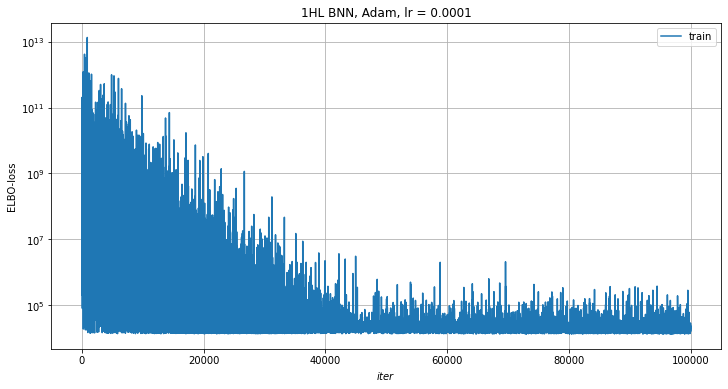

In [0]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), loss_arr, label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

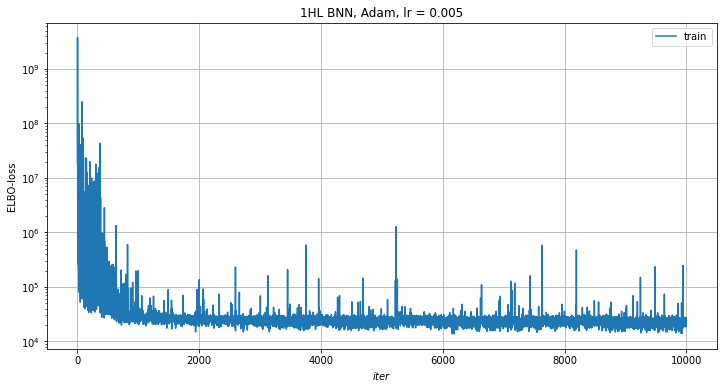

In [0]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), loss_arr, label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

In [0]:
mu_mean, mu_var, y_mean, y_var = model.sample(x_test = torch_test, 
                                               num_samples = 10000)

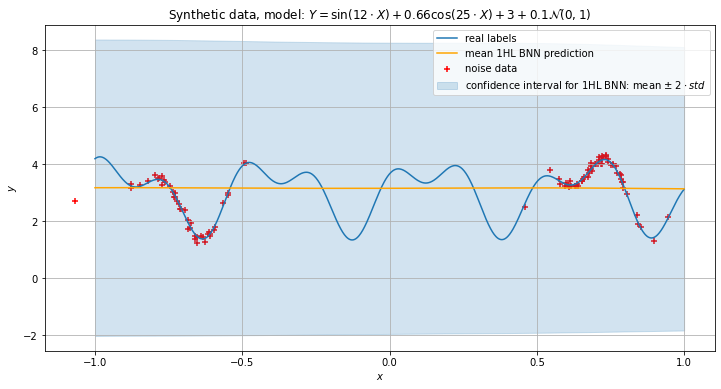

In [0]:
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mu_mean,
                   var_prediction = mu_var,
                   model_prediction_name = '1HL BNN')

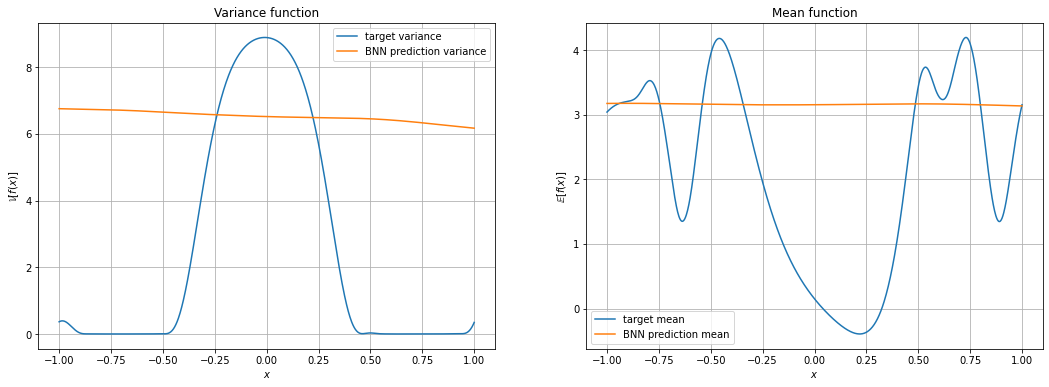

In [0]:
mean_gp_xx, var_gp_xx = np.array(gp.predict_f(xx))
plot_variance_and_mean(xx[:, 0], target_variance = var_gp_xx[:, 0], 
                       target_mean = mean_gp_xx,
                       prediction_variance = mu_var,
                       prediction_mean = mu_mean, figsize = (18, 6))

In [0]:
mu_mean, mu_var, y_mean, y_var = model.sample(x_test = torch_test, 
                                               num_samples = 50000)

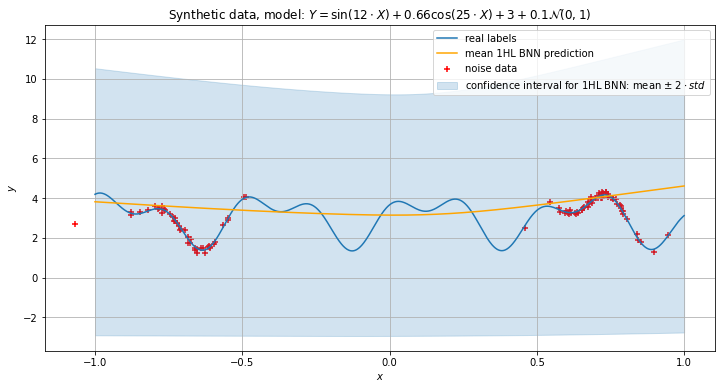

In [0]:
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mu_mean,
                   var_prediction = mu_var,
                   model_prediction_name = '1HL BNN')

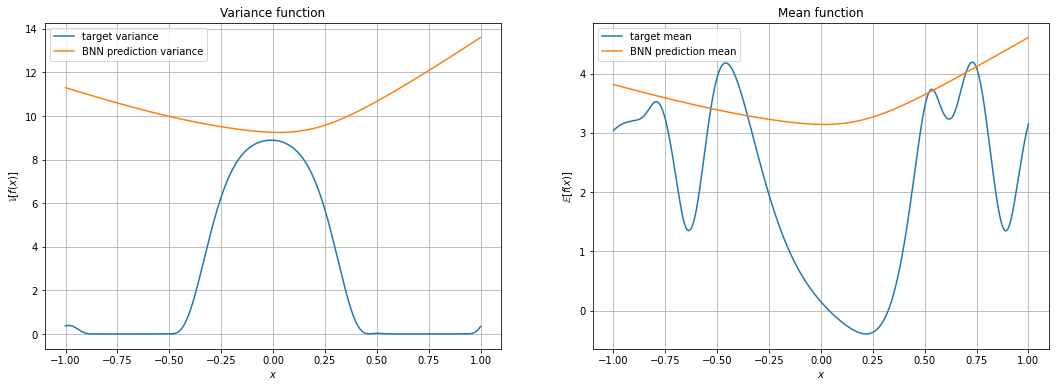

In [0]:
mean_gp_xx, var_gp_xx = np.array(gp.predict_f(xx))
plot_variance_and_mean(xx[:, 0], target_variance = var_gp_xx[:, 0], 
                       target_mean = mean_gp_xx,
                       prediction_variance = mu_var,
                       prediction_mean = mu_mean, figsize = (18, 6))

In [0]:
model_2 = BNN_1_layer(1, 50, learn_var = True)
torch_grid = torch.Tensor(data_1d)
torch_noise_labels = torch.Tensor(noise_labels)
xx = np.asarray(range_for_real_labels.reshape(1000, 1).numpy(), 
                dtype = 'float64')
torch_test = torch.Tensor(xx)

In [0]:
lr = 5e-3
num_epoch = 50000
loss_arr = model_2.train(x_train = torch_grid, 
                 y_train = torch_noise_labels, 
                 lr = lr,
                 num_epoch = num_epoch)

[iteration 0001] loss: 1446101.8294
[iteration 1001] loss: 13110.6440
[iteration 2001] loss: 12763.1814
[iteration 3001] loss: 16207.4262
[iteration 4001] loss: 13208.9508
[iteration 5001] loss: 14837.3502
[iteration 6001] loss: 9459.9684
[iteration 7001] loss: 8543.2805
[iteration 8001] loss: 8370.7681
[iteration 9001] loss: 8321.5587
[iteration 10001] loss: 8016.7076
[iteration 11001] loss: 7390.5629
[iteration 12001] loss: 6624.4345
[iteration 13001] loss: 4461.0011
[iteration 14001] loss: 1172.0197
[iteration 15001] loss: 411.1922
[iteration 16001] loss: 307.7467
[iteration 17001] loss: -117.4093
[iteration 18001] loss: 460.7755
[iteration 19001] loss: 12572.0676
[iteration 20001] loss: -250.4926
[iteration 21001] loss: -320.4832
[iteration 22001] loss: -446.6116
[iteration 23001] loss: -226.6717
[iteration 24001] loss: -267.3793
[iteration 25001] loss: -400.8174
[iteration 26001] loss: -375.0850
[iteration 27001] loss: -603.4861
[iteration 28001] loss: -631.7930
[iteration 29001] 

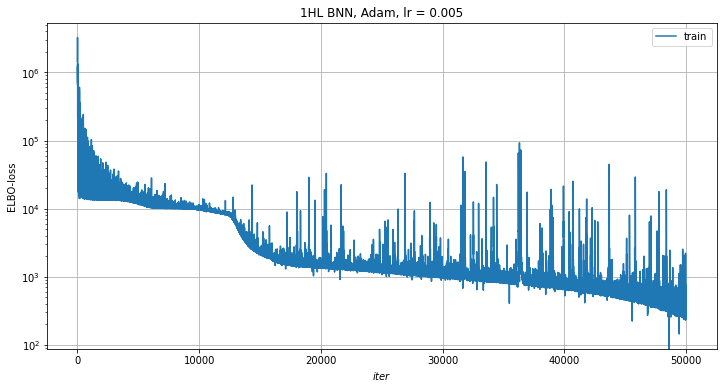

In [0]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), np.array(loss_arr) - min(loss_arr), label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

In [0]:
mu_mean, mu_var, y_mean, y_var = model_2.sample(x_test = torch_test, 
                                               num_samples = 1000)

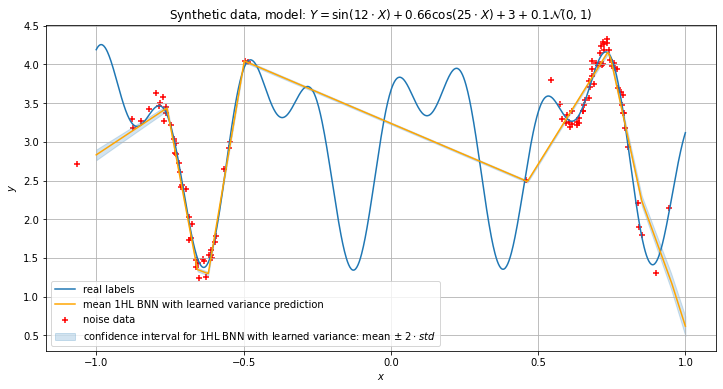

In [0]:
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mu_mean[:, 0],
                   var_prediction = mu_var[:, 0],
                   model_prediction_name = '1HL BNN with learned variance')

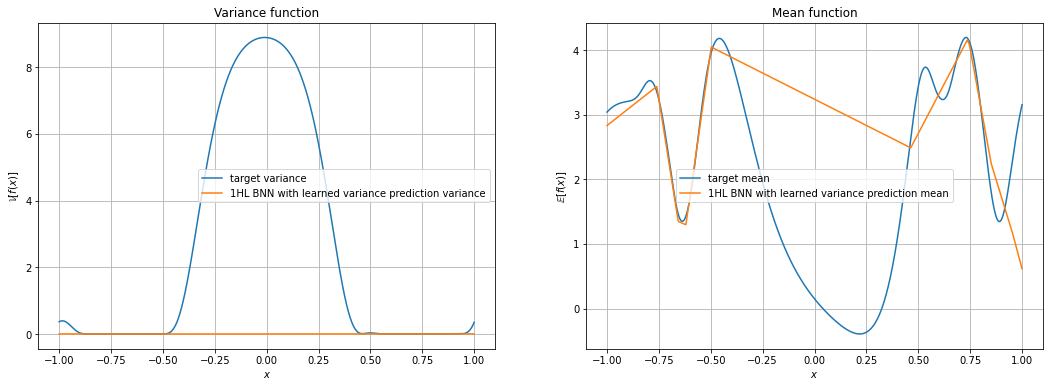

In [0]:
mean_gp_xx, var_gp_xx = np.array(gp.predict_f(xx))
plot_variance_and_mean(xx[:, 0], target_variance = var_gp_xx[:, 0], 
                       target_mean = mean_gp_xx,
                       prediction_variance = mu_var,
                       prediction_mean = mu_mean, figsize = (18, 6),
                       comparison_method = '1HL BNN with learned variance')

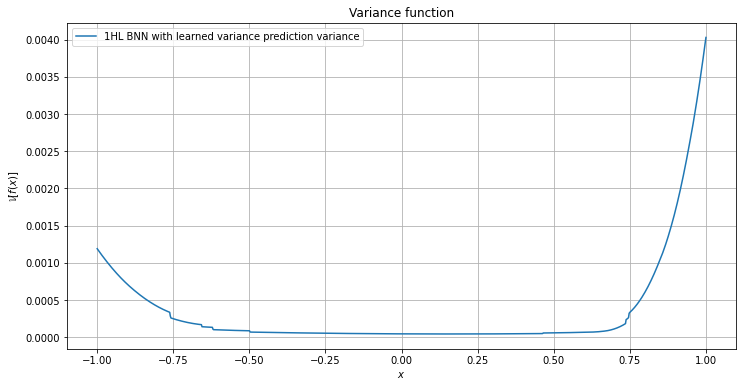

In [0]:
comparison_method = '1HL BNN with learned variance'
fig = plt.figure(figsize = (12, 6))
plt.xlabel(r'$x$')
plt.ylabel(r'$\mathbb{V}[f(x)]$')
plt.plot(xx[:, 0],  mu_var, label = comparison_method + ' prediction variance')
plt.title('Variance function')
plt.grid(True)
plt.legend()
plt.show()

## 2HL BNN

In [0]:
class BNN_2_layer(PyroModule):
    def __init__(self, in_features, num_hidden, learn_var = False):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, num_hidden)
        self.linear1.weight = PyroSample(dist.Normal(0., 1.).expand([num_hidden, in_features]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., 10.).expand([num_hidden]).to_event(1))
        self.learn_var = learn_var
        self.linear2 = PyroModule[nn.Linear](num_hidden, num_hidden)
        self.linear2.weight = PyroSample(dist.Normal(0., 1.).expand([num_hidden, num_hidden]).to_event(2))
        self.linear2.bias = PyroSample(dist.Normal(0., 10.).expand([num_hidden]).to_event(1))
        if not self.learn_var:
            self.linear3 = PyroModule[nn.Linear](num_hidden, 2)
            self.linear3.weight = PyroSample(dist.Normal(0., 1.).expand([2, num_hidden]).to_event(2))
            self.linear3.bias = PyroSample(dist.Normal(0., 10.).expand([2]).to_event(1))
        else:
            self.linear3 = PyroModule[nn.Linear](num_hidden, 1)
            self.linear3.weight = PyroSample(dist.Normal(0., 1.).expand([1, num_hidden]).to_event(2))
            self.linear3.bias = PyroSample(dist.Normal(0., 10.).expand([1]).to_event(1))

        self.guide = AutoDiagonalNormal(self)

    def forward(self, x, y = None):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        if not self.learn_var:
            mean = out[:, 0]
            std = F.softplus(out[:, 1])
        else:
            mean = out
            sigma = pyro.sample("sigma", dist.Normal(0., 10.))
            std = F.softplus(sigma)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, std), obs=y)
        return out

    def train(self, x_train, y_train, num_epoch = 80000, 
              lr = 1e-2, every_epoch_to_print = 1000):
        optimizer = Adam({"lr": lr})
        svi = SVI(self, self.guide, optimizer, 
                  loss = Trace_ELBO())
        pyro.clear_param_store()
        loss_arr = []
        for j in range(num_epoch):
            # calculate the loss and take a gradient step
            loss = svi.step(x_train, y_train)
            loss_arr.append(loss)
            if j % every_epoch_to_print == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss))
        return loss_arr

    def summary(self, samples):
        site_stats = {}
        for k, v in samples.items():
            if (k == "_RETURN" and (not self.learn_var)):
                site_stats[k] = {
                        "mean": torch.mean(v[:, :, 0], 0),
                        "std": torch.mean(F.softplus(v[:, :, 1]), 0)
                }
            else:
                site_stats[k] = {
                        "mean": torch.mean(v, 0),
                        "std": torch.std(v, 0)
                        }
        return site_stats

    def sample(self, x_test, num_samples = 128):
        self.guide.requires_grad_(False)

        predictive = Predictive(self, guide = self.guide, 
                                num_samples = num_samples,
                                return_sites = ("obs", "_RETURN"))
        samples = predictive(x_test)
        pred_summary = self.summary(samples)
        mu = pred_summary["_RETURN"]
        y = pred_summary["obs"]
        mu_mean = mu["mean"]
        mu_std = mu["std"]
        mu_var = mu_std.pow(2)
        y_mean = y["mean"]
        y_std = y["std"]
        y_var = y_std.pow(2)
        
        return mu_mean, mu_var, y_mean, y_var

In [0]:
model_3 = BNN_2_layer(1, 50)

In [0]:
lr = 1e-4
num_epoch = 50000
loss_arr = model_3.train(x_train = torch_grid, 
                 y_train = torch_noise_labels, 
                 lr = lr,
                 num_epoch = num_epoch)

[iteration 0001] loss: 95559677177.5592
[iteration 1001] loss: 434943679.1359
[iteration 2001] loss: 8542947906522.6494
[iteration 3001] loss: 459268395826.8725
[iteration 4001] loss: 1005837882025.9229
[iteration 5001] loss: 54023114.1803
[iteration 6001] loss: 68974.8064
[iteration 7001] loss: 113271539.3277
[iteration 8001] loss: 21534150.0309
[iteration 9001] loss: 71004209.6219
[iteration 10001] loss: 21631573.9591
[iteration 11001] loss: 7580071.4524
[iteration 12001] loss: 690993893481.8237
[iteration 13001] loss: 442755.2968
[iteration 14001] loss: 5222939.3097
[iteration 15001] loss: 74832252808.7166
[iteration 16001] loss: 33631878995.6522
[iteration 17001] loss: 79586832173.1648
[iteration 18001] loss: 13595070.8748
[iteration 19001] loss: 85997320.1211
[iteration 20001] loss: 2415078.1053
[iteration 21001] loss: 27716774.8638
[iteration 22001] loss: 18767634093.9454
[iteration 23001] loss: 3763443.6642
[iteration 24001] loss: 1832793.4160
[iteration 25001] loss: 30948.2552


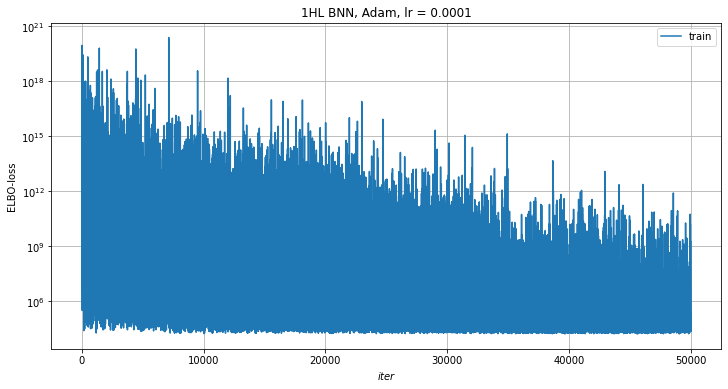

In [0]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), loss_arr, label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

In [0]:
mu_mean, mu_var, y_mean, y_var = model_3.sample(x_test = torch_test, 
                                               num_samples = 10000)

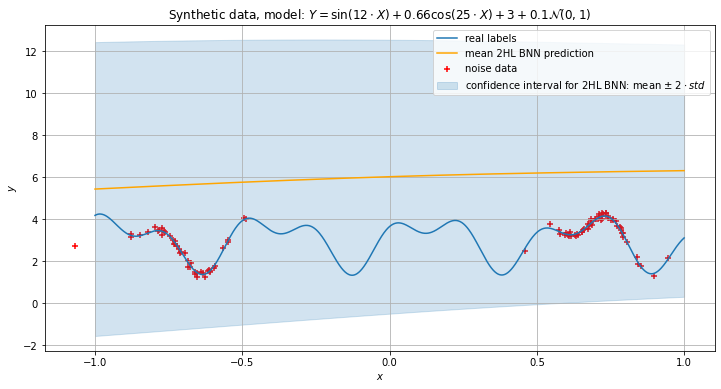

In [0]:
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mu_mean,
                   var_prediction = mu_var,
                   model_prediction_name = '2HL BNN')

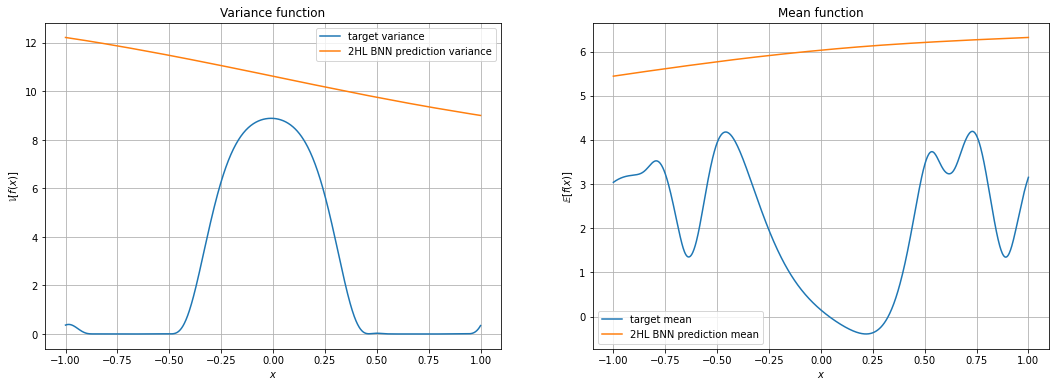

In [0]:
mean_gp_xx, var_gp_xx = np.array(gp.predict_f(xx))
plot_variance_and_mean(xx[:, 0], target_variance = var_gp_xx[:, 0], 
                       target_mean = mean_gp_xx,
                       prediction_variance = mu_var,
                       prediction_mean = mu_mean, figsize = (18, 6),
                       comparison_method = '2HL BNN')

In [0]:
model_4 = BNN_2_layer(1, 50, learn_var = True)

In [0]:
lr = 1e-4
num_epoch = 50000
loss_arr = model_4.train(x_train = torch_grid, 
                 y_train = torch_noise_labels, 
                 lr = lr,
                 num_epoch = num_epoch)

[iteration 0001] loss: 58750851.3589
[iteration 1001] loss: 1438965.8706
[iteration 2001] loss: 2098990.6579
[iteration 3001] loss: 889868.8519
[iteration 4001] loss: 8467425.2311
[iteration 5001] loss: 540722.7628
[iteration 6001] loss: 9984727.0535
[iteration 7001] loss: 4709377.0582
[iteration 8001] loss: 4956023.8060
[iteration 9001] loss: 854571.3448
[iteration 10001] loss: 370262.3488
[iteration 11001] loss: 574579.2748
[iteration 12001] loss: 300395.5403
[iteration 13001] loss: 543795.2288
[iteration 14001] loss: 501658.8038
[iteration 15001] loss: 2764486.6587
[iteration 16001] loss: 1320501.8415
[iteration 17001] loss: 293046.1903
[iteration 18001] loss: 474160.6105
[iteration 19001] loss: 1401766.0770
[iteration 20001] loss: 411186.5152
[iteration 21001] loss: 199812.0040
[iteration 22001] loss: 2552807.6024
[iteration 23001] loss: 984613.5930
[iteration 24001] loss: 122469.0125
[iteration 25001] loss: 194423.9916
[iteration 26001] loss: 103412.3157
[iteration 27001] loss: 91

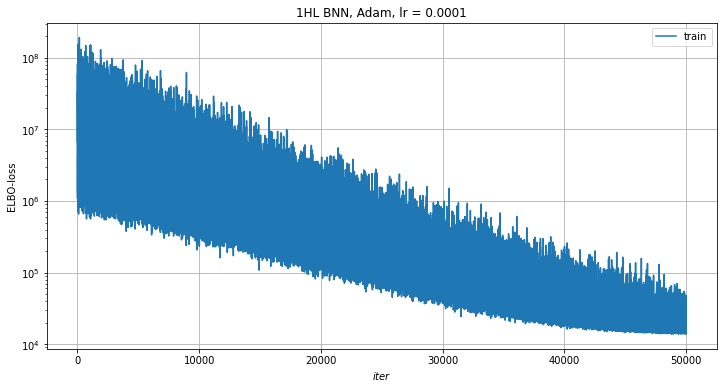

In [0]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), loss_arr, label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

In [0]:
mu_mean, mu_var, y_mean, y_var = model_4.sample(x_test = torch_test, 
                                               num_samples = 1000)

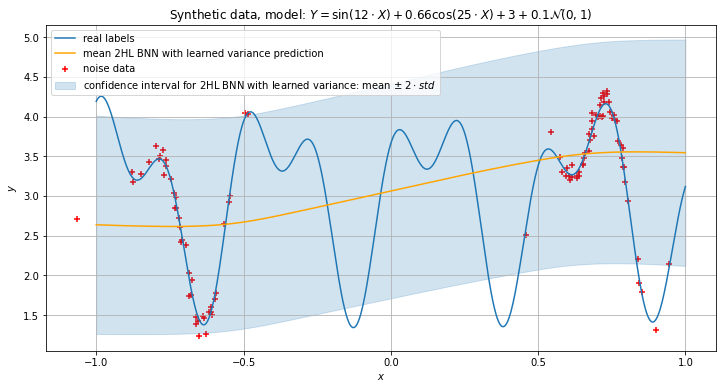

In [0]:
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mu_mean[:, 0],
                   var_prediction = mu_var[:, 0],
                   model_prediction_name = '2HL BNN with learned variance')

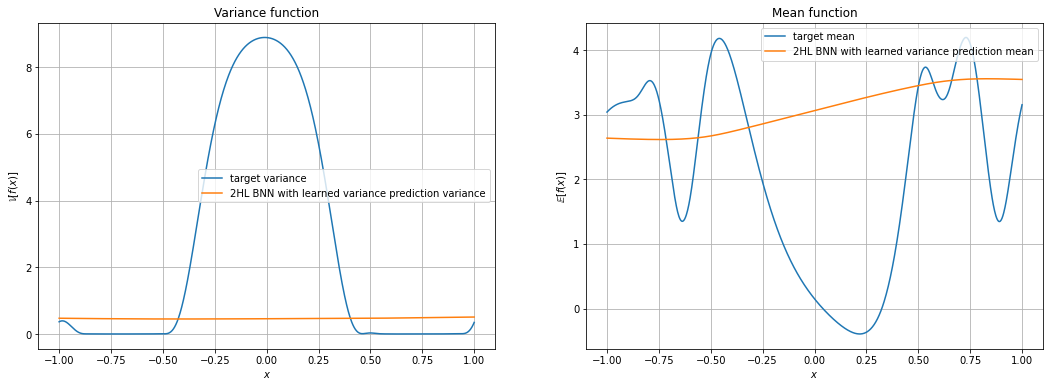

In [0]:
mean_gp_xx, var_gp_xx = np.array(gp.predict_f(xx))
plot_variance_and_mean(xx[:, 0], target_variance = var_gp_xx[:, 0], 
                       target_mean = mean_gp_xx,
                       prediction_variance = mu_var,
                       prediction_mean = mu_mean, figsize = (18, 6),
                       comparison_method = '2HL BNN with learned variance')

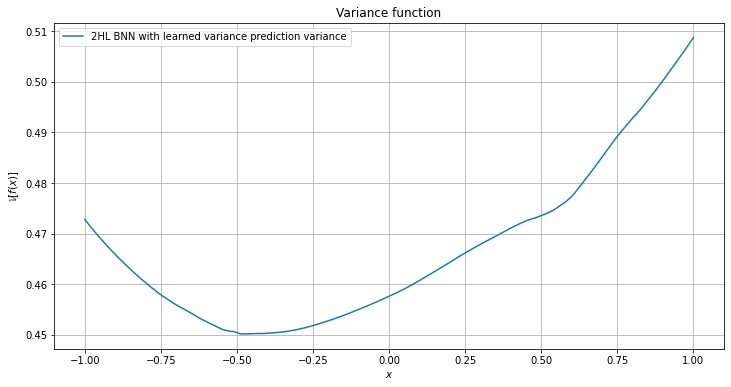

In [0]:
comparison_method = '2HL BNN with learned variance'
fig = plt.figure(figsize = (12, 6))
plt.xlabel(r'$x$')
plt.ylabel(r'$\mathbb{V}[f(x)]$')
plt.plot(xx[:, 0],  mu_var, label = comparison_method + ' prediction variance')
plt.title('Variance function')
plt.grid(True)
plt.legend()
plt.show()

## Training BNN on regression task, old Pyro primitives

In [0]:
num_hidden = 50 #hidden units
num_feature = 1  #num input dimensions
net = BNN_1HL(num_feature, num_hidden).cuda()

torch_noise_labels = torch.Tensor(noise_labels).cuda()
mean_gp, var_gp = gp.predict_f(grid)
torch_grid = torch.Tensor(grid).cuda()
torch_gp_pred_mean = torch.Tensor(np.array(mean_gp)).cuda()

In [0]:
num_epoch = 100000
lr = 1e-2
every_epoch_to_print = 1000
num_samples = 128
loss_arr, svi = net.train(x_train = torch_grid, 
                     y_train = torch_gp_pred_mean, 
                     num_epoch = num_epoch, lr = lr, 
                     num_samples = num_samples, 
                     every_epoch_to_print = every_epoch_to_print)

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:53: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


[iteration 0001] loss: 1242674628.0890
[iteration 1001] loss: 49796.4415
[iteration 2001] loss: 72124.3553
[iteration 3001] loss: 71094.2857
[iteration 4001] loss: 30423.5327
[iteration 5001] loss: 104493.0761
[iteration 6001] loss: 51707.2895
[iteration 7001] loss: 55373.4278
[iteration 8001] loss: 1754181.4252
[iteration 9001] loss: 31751.7128
[iteration 10001] loss: 46483.6102
[iteration 11001] loss: 134507.4701
[iteration 12001] loss: 116852.7573
[iteration 13001] loss: 30938.1157
[iteration 14001] loss: 34149.1948
[iteration 15001] loss: 46588.8525
[iteration 16001] loss: 60889.7096
[iteration 17001] loss: 65110.9217
[iteration 18001] loss: 67213.2262
[iteration 19001] loss: 41343.9170
[iteration 20001] loss: 34841.3491
[iteration 21001] loss: 26226.6801
[iteration 22001] loss: 65048.0507
[iteration 23001] loss: 25808.2584
[iteration 24001] loss: 37254.9528
[iteration 25001] loss: 43600.5330
[iteration 26001] loss: 34110.0048
[iteration 27001] loss: 32229.5713
[iteration 28001] lo

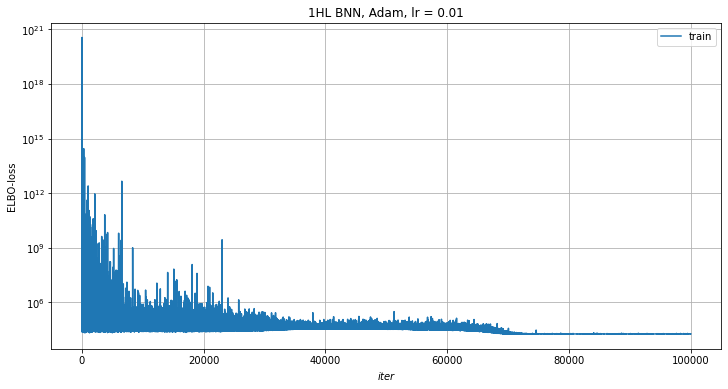

In [0]:
fig = plt.figure(figsize = (12, 6))

plt.xlabel(r'$iter$') 
plt.ylabel(r'ELBO-loss') 
plt.title(fr'1HL BNN, Adam, lr = {lr}') 

plt.plot(range(len(loss_arr)), loss_arr, label = 'train')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show() 

In [0]:
(mu_mean, mu_std, 
   y_obs_mean, y_obs_std) = net.sampling_prediction(svi = svi,
                                                    x_train = torch_grid, 
                                                    y_train = torch_gp_pred_mean,
                                                    x_test = torch_grid, 
                                                    num_samples = 10000)

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:89: FutureWarning: The `SVI.run` method is deprecated and will be removed in a future release. For inference, use `SVI.step` directly, and for predictions, use the `pyro.infer.Predictive` class.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyro/infer/abstract_infer.py:299: FutureWarning: The `TracePredictive` class is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  FutureWarning)


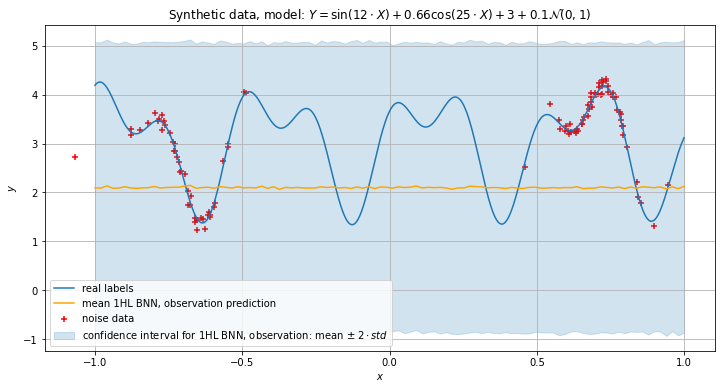

In [0]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = grid[:, 0],
                   mean_prediction = y_obs_mean,
                   var_prediction = np.power(y_obs_std, 2.0),
                   model_prediction_name = '1HL BNN, observation')

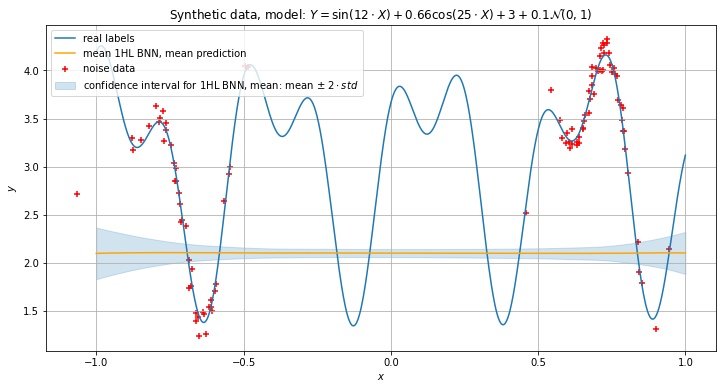

In [0]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = grid[:, 0],
                   mean_prediction = mu_mean,
                   var_prediction = np.power(mu_std, 2.0),
                   model_prediction_name = '1HL BNN, mean',
                   loc = "upper left")

In [0]:
def inference(x_data, num_samples, net):
    sampled_models = [net.guide(None, None) for _ in range(num_samples)]
    yhats = [model(x_data).data for model in sampled_models]
    result = torch.stack(yhats)
    mean_result = torch.mean(result, dim = 0)

    return mean_result

In [0]:
num_samples = 10000
pred = inference(x_data = torch_grid, 
              num_samples = num_samples, 
              net = net)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


In [0]:
prediction_var

tensor([2.2039, 2.2035, 2.2032, 2.2029, 2.2027, 2.2025, 2.2023, 2.2021, 2.2019,
        2.2016, 2.2014, 2.2012, 2.2010, 2.2008, 2.2007, 2.2005, 2.2004, 2.2002,
        2.2001, 2.1999, 2.1997, 2.1996, 2.1995, 2.1993, 2.1992, 2.1990, 2.1989,
        2.1988, 2.1986, 2.1985, 2.1983, 2.1982, 2.1981, 2.1980, 2.1979, 2.1978,
        2.1977, 2.1976, 2.1975, 2.1974, 2.1973, 2.1973, 2.1972, 2.1972, 2.1971,
        2.1971, 2.1970, 2.1970, 2.1970, 2.1970, 2.1969, 2.1969, 2.1969, 2.1969,
        2.1969, 2.1969, 2.1969, 2.1970, 2.1970, 2.1970, 2.1971, 2.1971, 2.1971,
        2.1972, 2.1972, 2.1973, 2.1973, 2.1974, 2.1975, 2.1976, 2.1977, 2.1977,
        2.1978, 2.1980, 2.1981, 2.1982, 2.1983, 2.1985, 2.1986, 2.1988, 2.1990,
        2.1992, 2.1993, 2.1995, 2.1997, 2.1999, 2.2001, 2.2004, 2.2006, 2.2008,
        2.2011, 2.2013, 2.2015, 2.2018, 2.2020, 2.2023, 2.2025, 2.2028, 2.2030,
        2.2033], device='cuda:0')

In [0]:
softplus = torch.nn.Softplus()
prediction_var = softplus(pred[:, 1])
prediction_mean = pred[:, 0]

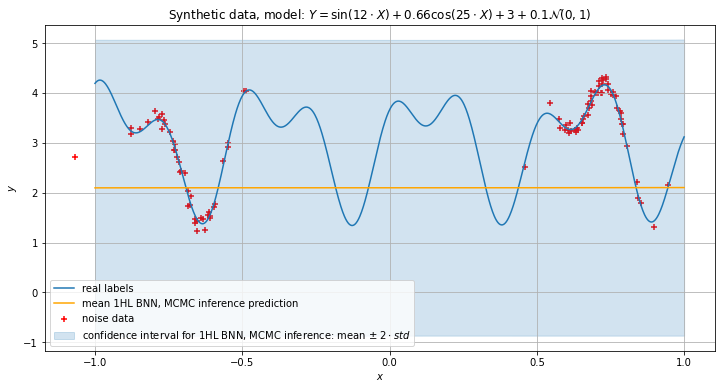

In [0]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = grid[:, 0],
                   mean_prediction = prediction_mean.cpu(),
                   var_prediction = prediction_var.cpu(),
                   model_prediction_name = '1HL BNN, MCMC inference')

## Training 1HL BNN, not done, l2-loss

In [ ]:
import pyro.contrib.bnn as bnn
from pyro.distributions import Normal, Delta

In [0]:
softplus = torch.nn.Softplus()
features = torch.Tensor(grid)
input_size = 1
n_hidden = 50
kl_factor = 1.0
n_features = features.size(0)
labels = torch.Tensor(np.stack((mean_gp_grid, var_gp_grid), axis=1)).view(n_features, 2)
# Set-up parameters for the distribution of weights for each layer `a<n>`
a1_mean = torch.zeros(input_size, n_hidden)
a1_scale = torch.ones(input_size, n_hidden) 
a2_mean = torch.zeros(n_hidden + 1, 2)
a2_scale = torch.ones(n_hidden + 1, 2)
# Mark batched calculations to be conditionally independent given parameters using `plate`
with pyro.plate('data', size = n_features):
    # Sample first hidden layer
    h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                            KL_factor = kl_factor))
    # Sample output 
    print(h1.shape)
    output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                    non_linearity=lambda x: x,
                                                    KL_factor=kl_factor, include_hidden_bias = False))
    mu_output = output[:, 0]
    sigma_inv_softplus_output = output[:, 1]
    sigma_output = softplus(sigma_inv_softplus_output)
    ans = pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 

torch.Size([100, 51])


In [0]:
ans.shape

torch.Size([100])

In [0]:
from __future__ import absolute_import, division, print_function

import torch

import pyro
import pyro.poutine as poutine
from pyro.infer.elbo import ELBO
from pyro.infer.util import torch_item

def model(features, labels = None, kl_factor=1.0): 
    n_features = features.size(0)
    n_hidden = 50
    input_size = 1
    # Set-up parameters for the distribution of weights for each layer `a<n>`
    a1_mean = torch.zeros(input_size, n_hidden)
    a1_scale = torch.ones(input_size, n_hidden) 
    a2_mean = torch.zeros(n_hidden + 1, 2)
    a2_scale = torch.ones(n_hidden + 1, 2)
    # Mark batched calculations to be conditionally independent given parameters using `plate`
    with pyro.plate('data', size = n_features):
        # Sample first hidden layer
        h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                KL_factor = kl_factor))
        # Sample output 
        output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                        non_linearity=lambda x: x,
                                                        KL_factor=kl_factor, include_hidden_bias = False))
        mu_output = output[:, 0]
        sigma_inv_softplus_output = output[:, 1]
        sigma_output = softplus(sigma_inv_softplus_output)
        return mu_output, sigma_output
        #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 

def guide(features, labels=None, kl_factor=1.0):
    n_features = features.size(0)
    n_hidden = 50
    input_size = 1
    # Set-up parameters to be optimized to approximate the true posterior
    a1_mean = pyro.param('a1_mean', torch.randn(input_size, n_hidden))
    a1_scale = softplus(pyro.param('a1_scale', torch.randn(input_size, n_hidden)))

    a2_mean = pyro.param('a2_mean', torch.randn(n_hidden + 1, n_hidden))
    a2_scale = softplus(pyro.param('a2_scale', torch.randn(n_hidden + 1, n_hidden)))

    # Sample latent values using the variational parameters that are set-up above.
    # Notice how there is no conditioning on labels in the guide!
    with pyro.plate('data', size = n_features):
        # Sample first hidden layer
        h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                KL_factor = kl_factor))
        # Sample output 
        output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                        non_linearity=lambda x: x,
                                                        KL_factor=kl_factor, include_hidden_bias = False))
        mu_output = output[:, 0]
        sigma_inv_softplus_output = output[:, 1]
        sigma_output = softplus(sigma_inv_softplus_output)
        #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 
        return mu_output, sigma_output

def simple_elbo(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())

def l2_loss_between_GP(mean_true, var_true, mean_pred_mc, var_pred_mc):
    loss = nn.MSELoss(reduction = 'sum')
    return loss(mean_true, mean_pred_mc) + loss(mean_pred_mc, var_pred_mc)

def my_l2_loss(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    X, num_samples, gp, kl_factor = args
    X_torch = torch.Tensor(X)
    sampled_means_and_vars = [guide(X_torch, kl_factor = kl_factor) for _ in range(num_samples)]
    means_predictions = [sampled_mean_and_var[0].data for sampled_mean_and_var in sampled_means_and_vars]
    var_predictions = [sampled_mean_and_var[1].data for sampled_mean_and_var in sampled_means_and_vars]
    mean = torch.mean(torch.stack(means_predictions), 0)
    var = torch.mean(torch.stack(var_predictions), 0)
    mean_gp, var_gp = np.array(gp.predict_f(X))  
    mean_gp_torch = torch.Tensor(mean_gp[:, 0])
    var_gp_torch = torch.Tensor(var_gp[:, 0])
    return l2_loss_between_GP(mean_gp_torch, var_gp_torch, mean, var)

num_samples = 128
kl_factor = 1.0
loss =  my_l2_loss(model, guide, grid, num_samples, gp, kl_factor)

In [0]:
from __future__ import absolute_import, division, print_function

import torch

import pyro
import pyro.poutine as poutine
from pyro.infer.elbo import ELBO
from pyro.infer.util import torch_item


class SVI(object):
    """
    :param model: the model (callable containing Pyro primitives)
    :param guide: the guide (callable containing Pyro primitives)
    :param optim: a wrapper a for a PyTorch optimizer
    :type optim: pyro.optim.PyroOptim
    :param loss: an instance of a subclass of :class:`~pyro.infer.elbo.ELBO`.
        Pyro provides three built-in losses:
        :class:`~pyro.infer.trace_elbo.Trace_ELBO`,
        :class:`~pyro.infer.tracegraph_elbo.Trace_ELBO`, and
        :class:`~pyro.infer.traceenum_elbo.Trace_ELBO`.
        See the :class:`~pyro.infer.elbo.ELBO` docs to learn how to implement
        a custom loss.
    :type loss: pyro.infer.elbo.ELBO

    A unified interface for stochastic variational inference in Pyro. The most
    commonly used loss is ``loss=Trace_ELBO()``. See the tutorial
    `SVI Part I <http://pyro.ai/examples/svi_part_i.html>`_ for a discussion.
    """
    def __init__(self,
                 model,
                 guide,
                 optim,
                 loss,
                 loss_and_grads=None,
                 **kwargs):
        self.model = model
        self.guide = guide
        self.optim = optim

        if isinstance(loss, ELBO):
            self.loss = loss.loss
            self.loss_and_grads = loss.loss_and_grads
        else:
            if loss_and_grads is None:
                def _loss_and_grads(*args, **kwargs):
                    loss_val = loss(*args, **kwargs)
                    print("start to do backward")
                    loss_val.backward()
                    return loss_val
                loss_and_grads = _loss_and_grads
            self.loss = loss
            self.loss_and_grads = loss_and_grads

    def evaluate_loss(self, *args, **kwargs):
        """
        :returns: estimate of the loss
        :rtype: float

        Evaluate the loss function. Any args or kwargs are passed to the model and guide.
        """
        with torch.no_grad():
            return torch_item(self.loss(self.model, self.guide, *args, **kwargs))


    def step(self, *args, **kwargs):
        """
        :returns: estimate of the loss
        :rtype: float

        Take a gradient step on the loss function (and any auxiliary loss functions
        generated under the hood by `loss_and_grads`).
        Any args or kwargs are passed to the model and guide
        """
        # get loss and compute gradients
        print("start to calculate gradients")
        with poutine.trace(param_only=True) as param_capture:
            loss = self.loss_and_grads(self.model, self.guide, *args, **kwargs)

        params = set(site["value"].unconstrained()
                     for site in param_capture.trace.nodes.values())

        # actually perform gradient steps
        # torch.optim objects gets instantiated for any params that haven't been seen yet
        self.optim(params)

        # zero gradients
        pyro.infer.util.zero_grads(params)

        return torch_item(loss)

In [0]:
class BNN_1HL(nn.Module):
    def __init__(self, input_size = 1, n_hidden = 50):
        super(BNN_1HL, self).__init__()
        self.input_size = input_size
        self.n_hidden = n_hidden
       
    def model(self, features, labels = None, kl_factor=1.0): 
        n_features = features.size(0)
        # Set-up parameters for the distribution of weights for each layer `a<n>`
        a1_mean = torch.zeros(self.input_size, self.n_hidden)
        a1_scale = torch.ones(self.input_size, self.n_hidden) 
        a2_mean = torch.zeros(self.n_hidden + 1, 2)
        a2_scale = torch.ones(self.n_hidden + 1, 2)
        # Mark batched calculations to be conditionally independent given parameters using `plate`
        with pyro.plate('data', size = n_features):
            # Sample first hidden layer
            h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                    KL_factor = kl_factor))
            # Sample output 
            output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                            non_linearity=lambda x: x,
                                                            KL_factor=kl_factor, include_hidden_bias = False))
            mu_output = output[:, 0]
            sigma_inv_softplus_output = output[:, 1]
            sigma_output = softplus(sigma_inv_softplus_output)
            #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output), obs = labels) 
            return mu_output, sigma_output
    
    def guide(self, features, labels=None, kl_factor=1.0):
        n_features = features.size(0)
        # Set-up parameters to be optimized to approximate the true posterior
        a1_mean = pyro.param('a1_mean', torch.randn(self.input_size, self.n_hidden))
        a1_scale = softplus(pyro.param('a1_scale', torch.randn(self.input_size, self.n_hidden)))

        a2_mean = pyro.param('a2_mean', torch.randn(self.n_hidden + 1, self.n_hidden))
        a2_scale = softplus(pyro.param('a2_scale', torch.randn(self.n_hidden + 1, self.n_hidden)))

        # Sample latent values using the variational parameters that are set-up above.
        # Notice how there is no conditioning on labels in the guide!
        with pyro.plate('data', size = n_features):
            # Sample first hidden layer
            h1 = pyro.sample('h1', bnn.HiddenLayer(features, a1_mean,  a1_scale, 
                                                    KL_factor = kl_factor))
            # Sample output 
            output = pyro.sample('bnn_output', bnn.HiddenLayer(h1, a2_mean, a2_scale,
                                                            non_linearity=lambda x: x,
                                                            KL_factor=kl_factor, include_hidden_bias = False))
            mu_output = output[:, 0]
            sigma_inv_softplus_output = output[:, 1]
            sigma_output = softplus(sigma_inv_softplus_output)
            #return pyro.sample('label', Normal(loc = mu_output, scale = sigma_output)) 
            return mu_output, sigma_output
    
    def infer_parameters_to_gp(self, X, gp, lr = 1e-3, num_samples = 128,
                         num_epochs = 10):
        optimizer = Adam({'lr': lr})
        svi = SVI(self.model, self.guide, optimizer, loss = my_l2_loss)
        kl_factor = X.shape[0]
        for i in range(num_epochs):
            print("start to do job")
            loss = svi.step(X, num_samples, gp, kl_factor)
            param_store = pyro.get_param_store()
            print(f"[Epoch {i + 1}], loss: {loss:.5E}")

In [0]:
input_size = 1
n_hidden = 50
simple_BNN = BNN_1HL(input_size = input_size, n_hidden = n_hidden)

In [0]:
lr = 1e-3
num_samples = 128
num_epochs = 10
simple_BNN.infer_parameters_to_gp(X = grid, gp = gp, lr = lr, 
                                  num_samples = num_samples, num_epochs = 10)

start to do job
start to calculate gradients
start to do bacward


RuntimeError: ignored

In [0]:
def predict(X, guide, mc_num_estimations, seed = None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    sampled_models = [guide(None, None) for _ in range(mc_num_estimations)]
    predictions = [model(X) for model in sampled_models]
    means_predictions = [predictions[:, 0].data for prediction in predictions]
    inv_softplus_var_predictions = [predictions[:, 1].data for prediction in predictions]
    mean = torch.mean(torch.stack(means_predictions), 0)
    inv_softplus_var = torch.mean(torch.stack(inv_softplus_var_predictions), 0)
    return mean, inv_softplus_var

def simple_elbo(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())


In [0]:
def train_simple_BNN(num_epochs, BNN, baseline_model, X, optimizer, 
              mc_num_estimations = 128, use_tensorboard = True,
              device = 'cuda:0', exp_name='BNN'):
    if use_tensorboard:
        writer = SummaryWriter(f'logs/{exp_name}')

    train_loss = []
    X_gpu = X.to(device)

    for epoch in range(num_epochs):        
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior

        model.zero_grad()
        mean_ = model(X_batch_gpu)
        
        loss = compute_loss(logits, y_batch, device = device)
        loss.backward()
        opt.step()

        if batch_no % 10 == 0:
            train_loss.append(loss.item())
            accuracy = compute_accuracy(logits, y_batch, device = device)
            train_accuracy_batch.append(accuracy.item())
            
            plot_loss_and_accuracy(train_loss, train_accuracy, val_accuracy, clear_output=True)
            print(f'epoch {epoch} training stage...')
            print(f"epoch {epoch}, train loss on batch = {loss.item()}")
            # SENDING LOSS TO TENSORBOARD
            if use_tensorboard:
                writer.add_scalar('train loss', loss.item(), global_step=len(train_loss))

            if (batch_no % 100 == 0) and (use_tensorboard):
                # SENDING PICTURES TO TENSORBOARD
                writer.add_image('train samples', make_grid(X_batch[:8], nrow=2), global_step=len(train_loss))
        if (batch_no == 0) and (use_tensorboard):
            # SENDING NETWORK GRAPH TO TENSORBOARD
            writer.add_graph(model, X_batch_gpu[:8])

        train_accuracy_overall = np.mean(train_accuracy_batch) * 100
        train_accuracy.append(train_accuracy_overall.item())

        # SENDING ACCURACY TO TENSORBOARD
        if use_tensorboard:
            writer.add_scalar('train accuracy', train_accuracy_overall.item(), epoch + 1)

        print(f'epoch {epoch} testing stage...')
        model.train(False) # disable dropout / use averages for batch_norm
        val_accuracy_batch = []
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch_gpu = X_batch.to(device)
            logits = model(X_batch_gpu)
            if not last_layer_logsoftmax:
                logits = nn.LogSoftmax(dim=1)(logits)
            accuracy = compute_accuracy(logits, y_batch, device=device)
            val_accuracy_batch.append(accuracy.item())
            
        val_accuracy_overall = np.mean(val_accuracy_batch) * 100
        val_accuracy.append(val_accuracy_overall.item())

        # SENDING ACCURACY TO TENSORBOARD
        print(f"epoch {epoch}, val accuracy = {val_accuracy_overall.item()}")
        if use_tensorboard:
            writer.add_scalar('val accuracy', val_accuracy_overall.item(), epoch + 1)

In [0]:
class BNN_1HL_FFG(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BNN_1HL_FFG, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)           
        output = self.out(output)
        return output

In [0]:
hidden_size = 50
net = BNN_1HL_FFG(input_size = 1, hidden_size = hidden_size, output_size = 1)

In [0]:
output = net(torch.Tensor(grid))

In [0]:
output.shape

torch.Size([100, 1])

In [0]:
def model_BNN_1HL_FFG(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
net.fc1.weight.shape

torch.Size([50, 1])

In [0]:
def guide_FFG(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior}
    hidden_arr_w_prior = []
    hidden_arr_b_prior = []
    for i in range(num_layers - 1):
        # hidden layer weight distribution priors
        hidden_cur_w_mu = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_w_sigma = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_param_str = "hidden" + str(i + 1)
        hidden_cur_w_mu_param_str = hidden_cur_param_str + "w_mu"
        hidden_cur_w_mu_param = pyro.param(hidden_cur_w_mu_param_str, hidden_cur_w_mu)
        hidden_cur_w_sigma_param_str = hidden_cur_param_str + "w_sigma"
        hidden_cur_w_sigma_param = softplus(pyro.param(hidden_cur_w_sigma_param_str, hidden_cur_w_sigma))
        hidden_cur_w_prior = Normal(loc=hidden_cur_w_mu_param, scale=hidden_cur_w_sigma_param)
        hidden_arr_w_prior.append(hidden_cur_w_prior)
        # hidden layer bias distribution priors
        hidden_cur_b_mu = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_sigma = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_mu_param_str = hidden_cur_param_str + "b_mu"
        hidden_cur_b_mu_param = pyro.param(hidden_cur_b_mu_param_str, hidden_cur_b_mu)
        hidden_cur_b_sigma_param_str = hidden_cur_param_str + "b_sigma"
        hidden_cur_b_sigma_param = softplus(pyro.param(hidden_cur_b_sigma_param_str, hidden_cur_b_sigma))
        hidden_cur_b_prior = Normal(loc=hidden_cur_b_mu_param, scale=hidden_cur_b_sigma_param)
        hidden_arr_b_prior.append(hidden_cur_b_prior)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors['out.weight'] = outw_prior
    priors['out.bias'] = outb_prior
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [0]:
class BNN_FFG(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(BNN_FFG, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) 
                                            for i in range(num_layers - 1)])
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        for layer in self.hidden_layers:
            output = layer(output)
            output = F.relu(output)            
        output = self.out(output)
        return output

In [0]:
num_layers = 1
hidden_size = 50
net = BNN_FFG(input_size = 1, num_layers = num_layers, 
              hidden_size = hidden_size, output_size = 1)

In [0]:
def guide_FFG(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior}
    hidden_arr_w_prior = []
    hidden_arr_b_prior = []
    for i in range(num_layers - 1):
        # hidden layer weight distribution priors
        hidden_cur_w_mu = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_w_sigma = torch.randn_like((net.hidden_layers)[i].weight)
        hidden_cur_param_str = "hidden" + str(i + 1)
        hidden_cur_w_mu_param_str = hidden_cur_param_str + "w_mu"
        hidden_cur_w_mu_param = pyro.param(hidden_cur_w_mu_param_str, hidden_cur_w_mu)
        hidden_cur_w_sigma_param_str = hidden_cur_param_str + "w_sigma"
        hidden_cur_w_sigma_param = softplus(pyro.param(hidden_cur_w_sigma_param_str, hidden_cur_w_sigma))
        hidden_cur_w_prior = Normal(loc=hidden_cur_w_mu_param, scale=hidden_cur_w_sigma_param)
        hidden_arr_w_prior.append(hidden_cur_w_prior)
        # hidden layer bias distribution priors
        hidden_cur_b_mu = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_sigma = torch.randn_like((net.hidden_layers)[i].bias)
        hidden_cur_b_mu_param_str = hidden_cur_param_str + "b_mu"
        hidden_cur_b_mu_param = pyro.param(hidden_cur_b_mu_param_str, hidden_cur_b_mu)
        hidden_cur_b_sigma_param_str = hidden_cur_param_str + "b_sigma"
        hidden_cur_b_sigma_param = softplus(pyro.param(hidden_cur_b_sigma_param_str, hidden_cur_b_sigma))
        hidden_cur_b_prior = Normal(loc=hidden_cur_b_mu_param, scale=hidden_cur_b_sigma_param)
        hidden_arr_b_prior.append(hidden_cur_b_prior)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors['out.weight'] = outw_prior
    priors['out.bias'] = outb_prior
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()